In [38]:
import math

import keras.dtensor.optimizers
#MATLABで作ったmatファイルを、matフォルダから読み取る
#matファイルは、変数がいくつか保存してあり、それぞれの中身を確認する
#matファイルの中身は、辞書型で保存されている
#辞書型の中身を確認するには、matlab.engineを使う
#matlab.engineを使うには、matlab.engineをインポートする必要がある

# !pip install tensorflow===2.11.0

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9696689634096923558
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 19932381184
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1344821249232970476
physical_device_desc: "device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:08:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2023-12-13 19:48:33.358241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 19:48:33.358568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 19:48:33.358829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [39]:
#GPUを用いて、tensorflowを使ったseq2seq回帰LSTMモデルを作成する
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.io


In [40]:

#データの読み込み
mat_file = 'mat/test_gen_bpsk_long.mat'
data = scipy.io.loadmat(mat_file)

#matファイルの中身の変数名を確認する

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Num_tx', 'R_xx', 'R_xx_after_Noise', 'R_xx_exist_Noise', 'SNR_dB', 'inputVec', 'label', 'noise', 's_t', 'sigmaX2', 'stter_vec', 't', 'x'])

In [41]:
a = data['R_xx']
# a = data['R_xx_exist_Noise']
b = data['inputVec']
c = data['label']

# d=data['sigmaX2']
# e=data['t']
#matに保存した変数の呼び出し
#a,b,cの次元数を確認する
print(a.shape)
print(b.shape)
print(c.shape)

#共分散行列
R = a


# #入力信号の電力
# sigmax2=d
# #スナップショット数
# t=e

#実数部と虚数部(虚数単位jは外す)に分ける関数
def split_complex(x):
    real = np.real(x)
    imag = np.imag(x)
    return real, imag


#実数部と虚数部に分ける
real, imag = split_complex(R)

#実数部と虚数部の次元数を確認する
print(real.shape)
print(imag.shape)

#実数部と虚数部を結合し、四次元配列に変換する
R = np.stack([real, imag], axis=3)

#Rの次元数を確認する
print(R.shape)

#Rはx(t)=As(t)+n(t)という信号モデルの共分散行列(Rはx(t)の複素共役転置の期待値)である（Aは方向行列、s(t)は入力信号、n(t)はガウス雑音）
#Rには、本来Aとs(t)とn(t)の情報が含まれているが、今回はn(t)を含まない
#Rにn(t)を乗せる処理を書く
#SNRを定義する
SNR = np.empty((1, 1))
np.append(SNR, 30)

#送信電力とSNRから雑音電力を求める
#送信電力は、sigmaX2である
#雑音電力は、sigmaN2である
# def calculate_noise_covariance(sigmaX2, SNR, t, R):
#     # 送信電力から雑音電力を計算する
#     # sigman2 = np.divide(sigmaX2, (10**(SNR/10)))
#     #
#     # # sigmaN2を表示する
#     # print(sigman2)
#     #
#     # # ガウス分布に従う雑音n(t)を生成する
#     # noise = np.sqrt(sigman2/2) * (np.random.randn(len(t),len(R[:,0,0,0])) + 1j*np.random.randn(len(t),len(R[:,0,0,0])))
#     #
#     # # n(t)の次元数を確認する
#     # print(noise.shape)
#
#     # # n(t)の共分散行列を求める
#     # N = np.dot(np.conj(noise).T, noise)
#     # N = N / len(t)
#     #
#     # # Nの次元数を確認する
#     # print("R_n", N.shape)
#
#     # Nの実部と虚部を分割する
#     real, imag = np.real(N), np.imag(N)
#
#     # Nを結合して次元数を確認する
#     N = np.stack([real, imag], axis=2)
#     print("R_n", N.shape)
#
#     return N




(10, 10, 10000)
(10000, 101)
(10000, 1)
(10, 10, 10000)
(10, 10, 10000)
(10, 10, 10000, 2)


array([ 0., 30.])

1


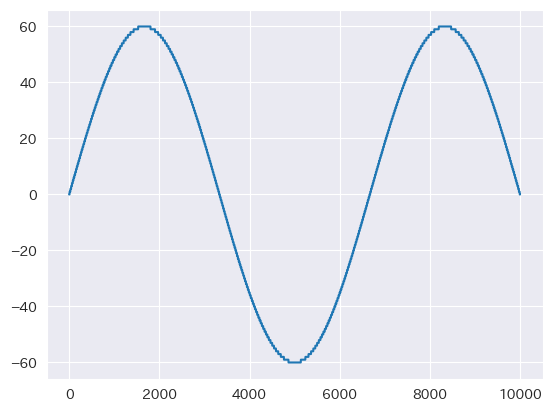

In [42]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

#tensorflowを使ったseq2seq回帰LSTMモデルを作成する

#分解能
min_angle = -90
max_angle = 90
resolution=1

print(resolution)
#matファイルで読み込んだinputVecとlabelからデータセットを作成する
#データセットは、inputVecとlabelの組み合わせで、入力と出力を作成する
X = R
Y = (np.round(c/resolution))*resolution


#Yをプロットする
plt.plot(Y)
plt.show()


In [43]:
#データセットを標準化する

#時系列画像データの標準化をする
#標準化すると、平均が0、標準偏差が1になる

from sklearn.preprocessing import StandardScaler

for j in range(X.shape[2]):
    for i in range(X.shape[3]):
        # シートごとのデータを抽出
        sheet_data = X[:, :, j, i]

        # 標準化器を作成し、データを標準化
        scaler = StandardScaler()
        sheet_data_standardized = scaler.fit_transform(sheet_data)

        # 標準化されたデータを元の配列に戻す
        X[:, :, j, i] = sheet_data_standardized



In [44]:
#データセットの特徴量の値の大部分が同じデータのみの場合にその行（もしくは列）を削除する

from sklearn.feature_selection import VarianceThreshold

for j in range(X.shape[2]):
    for i in range(X.shape[3]):
        sheet_data = X[:, :, j, i]  # シートごとのデータを抽出

        # VarianceThresholdを適用して行（もしくは列）を削除
        selector = VarianceThreshold()
        sheet_data_selected = selector.fit_transform(sheet_data)

        # 削除後のデータを元の配列に戻す
        if sheet_data_selected.ndim == 1:
            sheet_data_selected = sheet_data_selected.reshape(-1, 1)
        X[:, :, j, i] = sheet_data_selected

print(X.shape)

(10, 10, 10000, 2)


In [45]:
#Xを3次元配列に変換する
X = np.reshape(X, (X.shape[2], X.shape[0], X.shape[1], X.shape[3]))

print(X.shape)



(10000, 10, 10, 2)


In [46]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import LabelBinarizer


#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
train_size = 0.8
val_size = 0.1
test_size = 0.1


#Yを平坦化する
Y = Y.flatten()

#Yを表示する
print(Y)

from sklearn.preprocessing import LabelEncoder
#Yのユニークな値を表示する
u=np.arange(min_angle, max_angle+1.0, resolution)

import numpy as np
from sklearn.preprocessing import LabelBinarizer


transformer = LabelBinarizer().fit(u)

# ラベル → one-hot 表現
Y = transformer.transform(Y)
# print(Y)
# [[1 0 0]
#  [0 1 0]]

# # one-hot 表現 → ラベル
# src = transformer.inverse_transform(np.array([[1, 0, 0], [0, 1, 0]]))
# print(src)
# # ['A' 'B']

#Yを表示する
# print(target_one_hot)

[0. 0. 0. ... 0. 0. 0.]


In [47]:

#学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)

#学習データセットと検証データセットとテストデータセットの次元数を確認する
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)

#入力の次元はそれぞれ(サンプル数、タイムステップ数、特徴量)である
#Xの2番目の次元と3番目の次元を入れ替える
XTrain = np.swapaxes(XTrain, 1, 2)
XVal = np.swapaxes(XVal, 1, 2)
XTest = np.swapaxes(XTest, 1, 2)


(8000, 10, 10, 2)
(1000, 10, 10, 2)
(1000, 10, 10, 2)
(8000, 181)
(1000, 181)
(1000, 181)


In [48]:
#GPUを使ったLSTMmodelの作成

#tensorflowのバージョンを確認する
print(tf.__version__)


2.12.1


In [49]:

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

# from tensorflow.python.keras.optimizers import




In [50]:
# # TensorFlowの設定を変更
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # GPUメモリを必要に応じて割り当てるように設定
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

In [51]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

#モデルの層の作成(cudNNLSTM層を使用するためのインポート)
from tensorflow.keras.layers import LSTM

print((XTrain.shape[1:]))



hidden_units = 256
# 入力データの形状
# データの形状
input_shape = (X.shape[1], X.shape[2], X.shape[3])
time_steps = X.shape[0]



output_units = u.size  # 出力層のニューロン数
print(output_units)


(10, 10, 2)
181


In [53]:
import tensorflow as tf

#TimeDistributedを使用するためには tf.keras.layers.TimeDistributed を使用する必要がある

# ## モデルの定義
# model = Sequential()
#
# # 入力を(timesteps, height, width, channels)の形状に変形する
# # model.add(layers.Reshape((time_steps, image_height, image_width, channels), input_shape=(X.shape)))
#
# # 畳み込み層1
# model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
#
# # batch_normalization
# # model.add(normalization.normalization())
#
# #relu
# # model.add(layers.Activation('relu'))
#
# #プーリング層
# # model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#
# # 畳み込み層2
# model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#
# # batch_normalization
# model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
#
# #relu
# # model.add(layers.Activation('relu'))
#
# #プーリング層
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#
# # LSTM層に入力するために畳み込み層の出力を形状変換する
# model.add(layers.Reshape((-1, 16)))
#
#
# # LSTM層
# model.add(layers.CuDNNLSTM(units=hidden_units, return_sequences=True))
# model.add(layers.CuDNNLSTM(units=hidden_units, return_sequences=True))
# model.add(layers.CuDNNLSTM(units=hidden_units, return_sequences=True))
#
# # 全結合層
# model.add(layers.Dense(units=hidden_units, activation='relu'))
# model.add(layers.Dense(units=output_units,activation='sigmoid'))


In [54]:
# モデルの定義

max_epochs = 2000
mini_batch_size = 128


model = Sequential()

# CNN層
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(None,time_steps, X.shape[1], X.shape[2], X.shape[3])))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))

# LSTM層
model.add(layers.LSTM(64, return_sequences=False))

# 全結合層
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(output_units, activation='softmax'))

# モデルのコンパイル
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# モデルの概要の表示
# model.summary()

ValueError: Exception encountered when calling layer "time_distributed_6" (type TimeDistributed).

Input 0 of layer "max_pooling2d_2" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 10000, 8, 8, 32)

Call arguments received by layer "time_distributed_6" (type TimeDistributed):
  • inputs=tf.Tensor(shape=(None, None, 10000, 8, 8, 32), dtype=float32)
  • training=None
  • mask=None

In [ ]:
early_stopping = EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0,
                        patience=10,
                )

# val_lossの改善が2エポック見られなかったら、学習率を0.5倍する。
reduce_lr = ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.99,
                        patience=10,
                        min_lr=0.0001
                )

learning_rate = 0.01
opt = optimizers.adam_v2.Adam(learning_rate=learning_rate)


# opt = optimizers.adagrad_v2.Adagrad(learning_rate=learning_rate)
# コンパイル時にオプティマイザを指定する(損失関数はMSE、評価関数はRMSEをカスタムで実装)

loss_func = tf.keras.losses.MeanSquaredError(
    reduction='auto', name='mean_squared_error'
)

eval_func = tf.keras.metrics.RootMeanSquaredError(
    name='acuuracy', dtype=None
)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=eval_func)




In [ ]:
import shutil
import os

path1 = 'logs/train'
path2 = 'logs/validation'

# ログファイルを削除
if os.path.exists('logs/train'):
    shutil.rmtree(path1)
if os.path.exists('logs/validation'):
    shutil.rmtree(path2)

# TensorBoardコールバックを作成
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs')
#plotをlocalhostで表示

#ターミナルにコマンドを打つ
# tensorboard --logdir logs


In [ ]:

#モデルの学習

#モデルの学習の早期終了の設定
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


#モデルの学習
history = model.fit(XTrain, YTrain, batch_size=mini_batch_size, epochs=max_epochs, validation_data=(XVal, YVal),
                    callbacks=[reduce_lr,tensorboard])
#
#モデルの概要を表示する
model.summary()

In [ ]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
#モデルの保存

#モデルの保存
model.save('model/LSTM_classfication_model.h5')


In [ ]:
#モデルの読み込み

#モデルの読み込み
model = tf.keras.models.load_model('model/LSTMmodel.h5')

#モデルの概要を表示する
model.summary()

In [ ]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])



In [ ]:
#モデルの予測

#モデルの予測

#予測値を格納する変数を作成する
YTestPred = np.zeros((YTest.shape[0], 1))

#予測値を計算する
YTestPred = model.predict(XTest)

#予測値を表示する
# print(YTestPred[:, 0, :])

df1 = pd.DataFrame(YTestPred[:, 0, :], columns=['Predicton'])
df2 = pd.DataFrame(YTest[:, 0], columns=['True'])

df = pd.concat([df1, df2], axis=1)

df


In [ ]:
#予測値と正解値のグラフを表示する
print(YTestPred[:, 0, 0].shape)
print(YTest.shape)

#予測値と正解値を一つのグラフに表示する
plt.plot(YTestPred[:, 0, 0], label='YTestPred', color='red')
plt.plot(YTest[:, 0], label='YTest', linestyle='dashed', color='blue')
plt.ylim(-90, 90)
plt.legend()
plt.show()


In [ ]:
#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値のグラフを表示する

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を計算する
YTestDiff = ((YTestPred[:, 0, 0] - YTest[:, 0]))

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を表示する
print(YTestDiff.shape)

thr = np.arange(0, 10.5, 0.5)
numCorrect = np.zeros(len(thr))
numValidationImages = np.zeros(len(thr))
accuracy = np.zeros(len(thr))

for i in range(len(thr)):
    numCorrect[i] = np.sum(np.abs(YTestDiff) < thr[i])
    numValidationImages[i] = np.size(YTest[:, 0])
    accuracy[i] = numCorrect[i] / numValidationImages[i]

plt.scatter(thr, accuracy)
plt.xlabel("許容誤差(deg)")
plt.ylabel("accuracy")
plt.grid(True)
plt.plot(thr, accuracy, '.-', markersize=12)
plt.show()

In [ ]:
#予測値と正解値の差分のヒストグラムを表示する

#予測値と正解値の差分のヒストグラムを表示する
plt.hist(YTestDiff, bins=100)
plt.show()


In [ ]:
#予測値と正解値の差分の統計量を表示する

#予測値と正解値の差分の統計量を表示する
print(pd.DataFrame(YTestDiff).describe())


In [ ]:
#